In [11]:
import logging
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

# Model

In [12]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
        progressbar=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            _ = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=progressbar, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    np.hstack(
                        (
                            self.data["ds"].unique().to_numpy(),
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_numpy(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(
            future, self.mcmc_samples, self.map_approx, self.trace
        )

        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    future[f"{model_type}_{model_idx}_{group_code}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()

        group, _, groups_ = get_group_definition(self.data, pool_cols, "not_complete")
        for group_code, group_name in groups_.items():
            group_idx = group == group_code
            color = np.random.rand(3)
            plt.scatter(
                self.data["ds"][group_idx],
                self.data["y"][group_idx] * self.y_max,
                s=0.5,
                color=color,
                label=group_name,
            )

        if y_true is not None:
            test_group, _, test_groups_ = get_group_definition(
                y_true, pool_cols, "not_complete"
            )
            for group_code, group_name in test_groups_.items():
                group_idx = test_group == group_code
                color = np.random.rand(3)
                plt.scatter(
                    y_true["ds"][group_idx],
                    y_true["y"][group_idx],
                    s=0.5,
                    color=color,
                    label=f"y - {group_name}",
                )

        for group_code, group_name in groups_.items():
            plt.plot(
                future["ds"],
                future[f"yhat_{group_code}"],
                lw=1,
                label=f"yhat - {group_name}",
            )

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def metrics(self, y_true, future, pool_cols=None):
        metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        test_group, _, test_groups_ = get_group_definition(
            y_true, pool_cols, "not_complete"
        )
        for group_code, group_name in test_groups_.items():
            group_idx = test_group == group_code
            y = y_true["y"][group_idx]
            yhat = future[f"yhat_{group_code}"][-len(y) :]
            metrics["mse"][group_name] = mean_squared_error(y, yhat)
            metrics["rmse"][group_name] = root_mean_squared_error(y, yhat)
            metrics["mae"][group_name] = mean_absolute_error(y, yhat)
            metrics["mape"][group_name] = mean_absolute_percentage_error(y, yhat)

        return pd.DataFrame(metrics)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        self.group, self.n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        with model:
            if self.pool_type == "partial":
                sigma_slope = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_slope", beta=self.slope_sd
                )
                offset_slope = pm.Normal(
                    f"lt_{self.model_idx} - offset_slope",
                    mu=0,
                    sigma=1,
                    shape=self.n_groups,
                )
                slope = pm.Deterministic(
                    f"lt_{self.model_idx} - slope", offset_slope * sigma_slope
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                sigma_delta = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_delta", beta=delta_sd
                )
                offset_delta = pm.Laplace(
                    f"lt_{self.model_idx} - offset_delta",
                    0,
                    1,
                    shape=(self.n_groups, self.n_changepoints),
                )
                delta = pm.Deterministic(
                    f"lt_{self.model_idx} - delta", offset_delta * sigma_delta
                )
            else:
                slope = pm.Normal(
                    f"lt_{self.model_idx} - slope",
                    self.slope_mean,
                    self.slope_sd,
                    initval=initvals.get("slope", None),
                    shape=self.n_groups,
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                delta = pm.Laplace(
                    f"lt_{self.model_idx} - delta",
                    self.delta_mean,
                    delta_sd,
                    shape=(self.n_groups, self.n_changepoints),
                )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=self.n_groups,
            )

            if self.pool_type == "individual":
                ss = []
                t = np.array(data["t"])
                for group_code in range(self.n_groups):
                    series_data = data[self.group == group_code]
                    hist_size = int(
                        np.floor(series_data.shape[0] * self.changepoint_range)
                    )
                    cp_indexes = (
                        np.linspace(0, hist_size - 1, self.n_changepoints + 1)
                        .round()
                        .astype(int)
                    )
                    ss.append(np.array(series_data.iloc[cp_indexes]["t"].tail(-1)))

                self.s = np.stack(ss, axis=0)
                A = (t[:, None] > self.s[self.group]) * 1

                gamma = -self.s[self.group, :] * delta[self.group, :]
                trend = pm.Deterministic(
                    f"lt_{self.model_idx} - trend",
                    (slope[self.group] + pm.math.sum(A * delta[self.group], axis=1)) * t
                    + (intercept[self.group] + pm.math.sum(A * gamma, axis=1)),
                )
            else:
                t = np.array(data["t"])
                hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
                cp_indexes = (
                    np.linspace(0, hist_size - 1, self.n_changepoints + 1)
                    .round()
                    .astype(int)
                )
                self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))
                A = (t[:, None] > self.s) * 1

                gamma = -self.s * delta[self.group, :]
                trend = pm.Deterministic(
                    f"lt_{self.model_idx} - trend",
                    (slope[self.group] + pm.math.sum(A * delta[self.group], axis=1)) * t
                    + (intercept[self.group] + pm.math.sum(A * gamma, axis=1)),
                )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        if self.pool_type != "individual":
            new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            if self.pool_type == "individual":
                s = self.s[group_code]
                new_A = (np.array(future["t"])[:, None] > self.s[group_code]) * 1
            else:
                s = self.s

            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        if self.pool_type == "individual":
            new_A = (np.array(future["t"])[:, None] > self.s[self.group]) * 1
        else:
            new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                future["ds"],
                future[f"lt_{self.model_idx}_{group_code}"],
                lw=1,
                label=group_name,
            )

        plt.legend()


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        shrinkage_strength=100,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd
        self.shrinkage_strength = shrinkage_strength

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            if self.pool_type == "partial":
                mu_beta = pm.Normal(
                    f"fs_{self.model_idx} - beta_mu(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=2 * self.series_order,
                    initval=beta_initval,
                )
                sigma_beta = pm.HalfNormal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    sigma=self.beta_sd / self.shrinkage_strength,
                    shape=2 * self.series_order,
                )
                offset_beta = pm.Normal(
                    f"fs_{self.model_idx} - offset_beta(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=1,
                    shape=(n_groups, 2 * self.series_order),
                )

                beta = pm.Deterministic(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu_beta + offset_beta * sigma_beta,
                )
            else:
                beta = pm.Normal(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=(n_groups, 2 * self.series_order),
                    initval=beta_initval,
                )

        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[-int(self.period) :],
                future[f"fs_{self.model_idx}_{group_code}"][-int(self.period) :],
                lw=1,
                label=group_name,
            )

        plt.legend()


class Constant(TimeSeriesModel):
    def __init__(self, lower, upper, pool_cols=None, pool_type="complete"):
        self.lower = lower
        self.upper = upper
        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["c"] = model_idxs.get("c", 0)
        self.model_idx = model_idxs["c"]
        model_idxs["c"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        with model:
            if self.pool_type == "partial":
                mu_c = pm.Uniform(
                    f"c_{self.model_idx} - mu_c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )
                offset_c = pm.Normal(
                    f"c_{self.model_idx} - offset_c(l={self.lower},u={self.upper})",
                    mu=0,
                    sigma=1,
                    shape=n_groups,
                )
                c = pm.Deterministic(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    mu_c + offset_c,
                )
            else:
                c = pm.Uniform(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )

        return c[group]

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * map_approx[f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"][
                    group_code
                ]
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * trace["posterior"][
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"
                ]
                .to_numpy()[:, :, group_code]
                .mean()
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"c_{self.model_idx} - c(l={self.lower},u={self.upper})")

        plot_data = []
        for group_code, group_name in self.groups_.items():
            plot_data.append(
                (group_name, future[f"c_{self.model_idx}_{group_code}"][0])
            )

        plt.bar(*zip(*plot_data))
        plt.axhline(0, c="k", linewidth=3)

# Fetch data

In [4]:
# indexes = ["^W5000", "^GSPC", "^IXIC", "^DJI"]
indexes = ["^GSPC"]

gspc_tickers = [
    "AAPL", "MSFT", "AMZN", "FB", "TSLA", "GOOGL", "GOOG", "JNJ", "JPM", "V",
    "PG", "UNH", "DIS", "NVDA", "MA", "HD", "PYPL", "VZ", "ADBE", "CMCSA",
    "NFLX", "BAC", "KO", "MRK", "PEP", "T", "PFE", "INTC", "CRM", "WMT", "ABT",
    "ABBV", "CSCO", "TMO", "NKE", "AVGO", "XOM", "QCOM", "COST", "ACN", "CVX",
    "MCD", "MDT", "NEE", "TXN", "HON", "DHR", "UNP", "BMY", "LIN", "LLY",
    "AMGN", "PM", "C", "SBUX", "WFC", "ORCL", "UPS", "LOW", "BA", "IBM", "AMD",
    "RTX", "NOW", "BLK", "MMM", "INTU", "AMT", "CAT", "MS", "CHTR", "ISRG",
    "GE", "BKNG", "GS", "CVS", "TGT", "FIS", "LMT", "DE", "MU", "MDLZ", "TJX",
    "SYK", "ANTM", "SCHW", "SPGI", "AXP", "AMAT", "TMUS", "ZTS", "MO", "ADP",
    "CI", "PLD", "CL", "GILD", "BDX", "ATVI", "CB", "CSX", "CCI", "LRCX",
    "DUK", "ADSK", "FISV", "CME", "SO", "ICE", "TFC", "GPN", "USB", "EQIX",
    "PNC", "FDX", "VRTX", "D", "APD", "NSC", "EL", "SHW", "MMC", "ITW", "PGR",
    "EW", "ADI", "HUM", "ILMN", "ECL", "GM", "DD", "DG", "BSX", "REGN", "AON",
    "NEM", "EMR", "ETN", "NOC", "MCO", "KMB", "WM", "COF", "ROP", "CTSH",
    "ROST", "HCA", "TWTR", "COP", "IDXX", "EA", "AEP", "EXC", "DOW", "BAX",
    "TEL", "KLAC", "LHX", "SNPS", "APH", "DLR", "CMG", "ALGN", "CDNS", "SYY",
    "FCX", "BIIB", "STZ", "MSCI", "SRE", "A", "MCHP", "GIS", "MET", "TRV",
    "DXCM", "APTV", "PSA", "PH", "MAR", "XEL", "TT", "CNC", "XLNX", "GD", "BK",
    "F", "IQV", "TROW", "ALXN", "MNST", "PPG", "HPQ", "VRSK", "JCI", "TDG",
    "CMI", "INFO", "ALL", "EBAY", "ORLY", "YUM", "AIG", "ZBH", "SBAC", "ANSS",
    "CTAS", "PRU", "HLT", "RMD", "CARR", "PSX", "BLL", "SLB", "PCAR", "PAYX",
    "ES", "PEG", "ROK", "EOG", "AFL", "WEC", "CTVA", "MSI", "WBA", "SWK",
    "ADM", "FAST", "SPG", "MCK", "AME", "AWK", "DFS", "LUV", "OTIS", "GLW",
    "AZO", "VFC", "WLTW", "MTD", "WELL", "MPC", "KMI", "CPRT", "STT", "DAL",
    "FRC", "CLX", "DLTR", "SWKS", "WY", "ED", "KR", "KEYS", "WMB", "CERN",
    "TTWO", "FTV", "AJG", "EIX", "MKC", "MXIM", "LYB", "DTE", "EFX", "VLO",
    "BBY", "AMP", "DHI", "FLT", "VTRS", "HSY", "KHC", "AVB", "PAYC", "ETSY",
    "O", "VRSN", "PPL", "CHD", "MKTX", "ARE", "VIAC", "CBRE", "LEN", "WST",
    "ZBRA", "EQR", "RSG", "SIVB", "FTNT", "ETR", "TER", "LH", "VMC", "FITB",
    "LVS", "IP", "NTRS", "AEE", "TFX", "KSU", "QRVO", "TSN", "SYF", "CDW",
    "ODFL", "PXD", "HOLX", "AMCR", "GWW", "VTR", "XYL", "DOV", "EXPE", "GRMN",
    "COO", "CAG", "BR", "MLM", "TYL", "HIG", "CMS", "CTLT", "AKAM", "OKE",
    "IR", "WDC", "URI", "HAL", "FE", "TSCO", "MTB", "PEAK", "INCY", "ULTA",
    "STE", "CCL", "EXPD", "PKI", "NUE", "DGX", "KEY", "CTXS", "VAR", "K",
    "ANET", "CAH", "ALB", "AES", "DRI", "KMX", "RF", "ESS", "WAT", "CFG",
    "HPE", "NDAQ", "CE", "DPZ", "IEX", "EXR", "POOL", "FMC", "DRE", "NTAP",
    "ABMD", "OXY", "MAA", "GPC", "TDY", "HES", "ABC", "MAS", "IT", "NVR",
    "TIF", "J", "LDOS", "BKR", "STX", "RCL", "EMN", "OMC", "BXP", "SJM", "WAB",
    "HRL", "PKG", "CINF", "AVY", "MGM", "LNT", "HBAN", "CHRW", "PFG", "UAL",
    "EVRG", "BIO", "JKHY", "NLOK", "HAS", "ATO", "FBHS", "CNP", "RJF", "IFF",
    "PHM", "LW", "CXO", "XRAY", "WRK", "JBHT", "UDR", "WHR", "HWM", "TXT",
    "WYNN", "FFIV", "ALLE", "AAP", "UHS", "L", "LYV", "HST", "CBOE", "PWR",
    "LKQ", "FOXA", "CPB", "AAL", "LUMN", "HSIC", "BWA", "RE", "WRB", "SNA",
    "IPG", "NRG", "GL", "LNC", "WU", "PNW", "PNR", "NI", "LB", "DVA", "ROL",
    "TPR", "TAP", "IRM", "MHK", "CF", "AIZ", "NCLH", "NWL", "DISH", "IPGP",
    "MOS", "CMA", "DISCK", "FANG", "NLSN", "AOS", "JNPR", "REG", "ZION", "RHI",
    "SEE", "NWSA", "HII", "BEN", "PVH", "IVZ", "DXC", "COG", "KIM", "ALK",
    "PRGO", "DVN", "LEG", "FRT", "VNO", "FLIR", "PBCT", "APA", "NOV", "MRO",
    "HBI", "RL", "DISCA", "FLS", "UNM", "VNT", "FOX", "SLG", "GPS", "FTI",
    "XRX", "HFC", "UAA", "UA", "NWS"
]

# dji_tickers = [
#     "DIS", "WMT", "DOW", "NKE", "CRM", "HD", "V", "MSFT", "MMM", "CSCO", "KO",
#     "AAPL", "HON", "JNJ", "TRV", "PG", "CVX", "VZ", "CAT", "BA", "AMGN", "IBM",
#     "AXP", "JPM", "WBA", "MCD", "MRK", "GS", "UNH", "INTC"
# ]

# ixic_tickers = [
#     "FEYE", "ATEC", "SLAB", "CMRX", "NVCR", "FNLC", "NMRK", "SCOR", "AGLE",
#     "FARO", "OLMA", "TSLA", "FRTA", "AKTX", "KLXE", "CVCO", "NVCN", "EXAS",
#     "SDC", "BBQ", "IFRX", "CIIC", "BBI", "FNKO", "TWST", "FARM", "ACCD",
#     "NMRD", "FRSX", "OPTT"
# ]

all_tickers = indexes + list(set(gspc_tickers))

data = yfinance.download(
    all_tickers,
    interval="1d",
    start="2000-01-01",
    end="2020-01-01",
)
data

[*********************100%***********************]  504 of 504 completed

44 Failed downloads:
['LB', 'VNT', 'INFO', 'OTIS', 'CARR', 'FISV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2000-01-01 -> 2020-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1577854800")')
['TWTR', 'VAR', 'HFC', 'TIF', 'PBCT', 'CERN', 'SIVB', 'KSU', 'DISH', 'ABMD', 'ABC', 'VIAC', 'FRC', 'NLOK', 'DISCA', 'WRK', 'FBHS', 'RE', 'FLT', 'BLL', 'PXD', 'COG', 'ANTM', 'FB', 'PKI', 'FLIR', 'CXO', 'ATVI', 'WLTW', 'PEAK', 'NLSN', 'DRE', 'MXIM', 'GPS', 'DISCK', 'CTXS', 'ALXN', 'XLNX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Price       Adj Close                                                        \
Ticker              A        AAL         AAP       AAPL       ABBV ABC ABMD   
Date                                                                          
2000-01-03  43.463032        NaN         NaN   0.843076        NaN NaN  NaN   
2000-01-04  40.142941        NaN         NaN   0.771997        NaN NaN  NaN   
2000-01-05  37.652866        NaN         NaN   0.783293        NaN NaN  NaN   
2000-01-06  36.219189        NaN         NaN   0.715508        NaN NaN  NaN   
2000-01-07  39.237446        NaN         NaN   0.749401        NaN NaN  NaN   
...               ...        ...         ...        ...        ...  ..  ...   
2019-12-24  82.411537  29.072563  145.651276  68.898697  72.506981 NaN  NaN   
2019-12-26  82.556450  29.560759  144.472076  70.265671  72.490829 NaN  NaN   
2019-12-27  82.527466  28.335287  143.637543  70.239006  71.982437 NaN  NaN   
2019-12-30  82.198280  28.195801  144.336014  70.655884  71.433693 NaN  NaN   
2019-12-31  82.595245  28.574404  145.279373  71.172127  71.449837 NaN  NaN   

Price                                          ...    Volume           \
Ticker            ABT         ACN        ADBE  ...       XOM     XRAY   
Date                                           ...                      
2000-01-03   8.288179         NaN   16.274673  ...  13458200   582300   
2000-01-04   8.051379         NaN   14.909398  ...  14510800   317700   
2000-01-05   8.036574         NaN   15.204174  ...  17485000  1188000   
2000-01-06   8.317780         NaN   15.328287  ...  19461600   534300   
2000-01-07   8.406584         NaN   16.072983  ...  16603800  1401000   
...               ...         ...         ...  ...       ...      ...   
2019-12-24  79.992409  196.620178  329.640015  ...   3979400   579400   
2019-12-26  79.992409  197.029007  331.200012  ...   8840200   708800   
2019-12-27  80.102379  197.186966  330.790009  ...  10516100   664700   
2019-12-30  79.552467  195.718872  328.339996  ...  12689400  1283000   
2019-12-31  79.607475  195.653854  329.809998  ...  13151800  1211000   

Price                                                                          \
Ticker          XRX       XYL      YUM       ZBH     ZBRA     ZION        ZTS   
Date                                                                            
2000-01-03  3329164       NaN  3033493       NaN  1055700  1199600        NaN   
2000-01-04  2361970       NaN  3315031       NaN   522450   816100        NaN   
2000-01-05  2375404       NaN  4642602       NaN   612225  1124700        NaN   
2000-01-06  1650180       NaN  3947658       NaN   263925  1112100        NaN   
2000-01-07  2366942       NaN  6063647       NaN   333900   782000        NaN   
...             ...       ...      ...       ...      ...      ...        ...   
2019-12-24   416600  184600.0   656400  252350.0   164400   312600   442500.0   
2019-12-26   776800  427500.0  1176900  630051.0   255200   586400   929400.0   
2019-12-27  1163800  346700.0  1130500  403657.0   214100   921600  1296100.0   
2019-12-30  1083600  523800.0  1185800  607494.0   339100  1511600   942000.0   
2019-12-31  1380100  492000.0  1271000  630772.0   363500  1246900  1128600.0   

Price                   
Ticker           ^GSPC  
Date                    
2000-01-03   931800000  
2000-01-04  1009000000  
2000-01-05  1085500000  
2000-01-06  1092300000  
2000-01-07  1225200000  
...                ...  
2019-12-24  1296530000  
2019-12-26  2164540000  
2019-12-27  2429150000  
2019-12-30  3021720000  
2019-12-31  2894760000  

[5031 rows x 3024 columns]

In [5]:
downloaded_tickers = list({col[1] for col in data.columns})
len(downloaded_tickers)

504

In [6]:
dfs = []
for ticker in ["^GSPC"] + gspc_tickers:
    if ticker not in downloaded_tickers:
        continue

    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": (
                (
                    data["Open"][ticker]
                    + data["High"][ticker]
                    + data["Low"][ticker]
                    + data["Close"][ticker]
                )
                / 4
            ).to_numpy(),
        },
        index=data["Adj Close"][ticker].index,
    )

    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Experiments

In [13]:
def generate_train_test_df(start, window, horizon, dfs, for_prophet=False):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        if df.isna().any().any():
            continue

        train_df = df[start : start + window].copy()
        scales.append(train_df["typical_price"].max())
        train_df["y"] = train_df["typical_price"] / scales[-1]
        test_df = df[start + window : start + window + horizon].copy()
        test_df["y"] = test_df["typical_price"] / scales[-1]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    if for_prophet:
        return train_dfs, test_dfs, scales

    if len(train_dfs) == 0:
        return None

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

## 2008 financial crisis

In [14]:
def generate_train_test_df_financial_crisis(window, horizon, dfs, for_prophet=False):
    year_after_financial_crisis_idx = len(dfs[0][dfs[0]["ds"] < "2009-09-01"])
    start = year_after_financial_crisis_idx - window
    return generate_train_test_df(start, window, horizon, dfs, for_prophet)

### 9 years + 1 year suffix

In [102]:
metrics = []

for df in tqdm(dfs):
    check = generate_train_test_df_financial_crisis(
        window=365 * 9, horizon=365, dfs=[df]
    )
    if check is None:
        continue

    train_df_1, test_df_1, scales_1 = check
    train_df_2, test_df_2, scales_2 = generate_train_test_df_financial_crisis(
        window=365 * 1, horizon=365, dfs=[df]
    )
    train_df_2["series"] += "_small"
    test_df_2["series"] += "_small"
    train_df = pd.concat((train_df_1, train_df_2))
    test_df = pd.concat((test_df_1, train_df_2))

    model = LinearTrend(
        pool_cols="series", pool_type="individual", n_changepoints=25
    ) * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    )
    model.fit(train_df, use_prophet_initvals=False, progressbar=False)
    yhat = model.predict(365)
    metrics.append(model.metrics(test_df, yhat, pool_cols="series"))

metrics = pd.concat(metrics)
metrics

100%|██████████| 50/50 [08:24<00:00, 10.09s/it]


,mse,rmse,mae,mape
^GSPC,0.139383,0.373341,0.363559,0.512862
^GSPC_small,0.030896,0.175772,0.173489,0.243403
AAPL,0.444225,0.666502,0.646104,0.570239
AAPL_small,0.000540,0.023243,0.019228,0.029503
MSFT,0.135718,0.368399,0.360960,0.481097
...,...,...,...,...
DHR_small,0.033684,0.183532,0.181402,0.253468
UNP,0.107363,0.327664,0.314691,0.379806
UNP_small,0.062262,0.249525,0.243824,0.390103
BMY,0.010720,0.103537,0.098270,0.278363


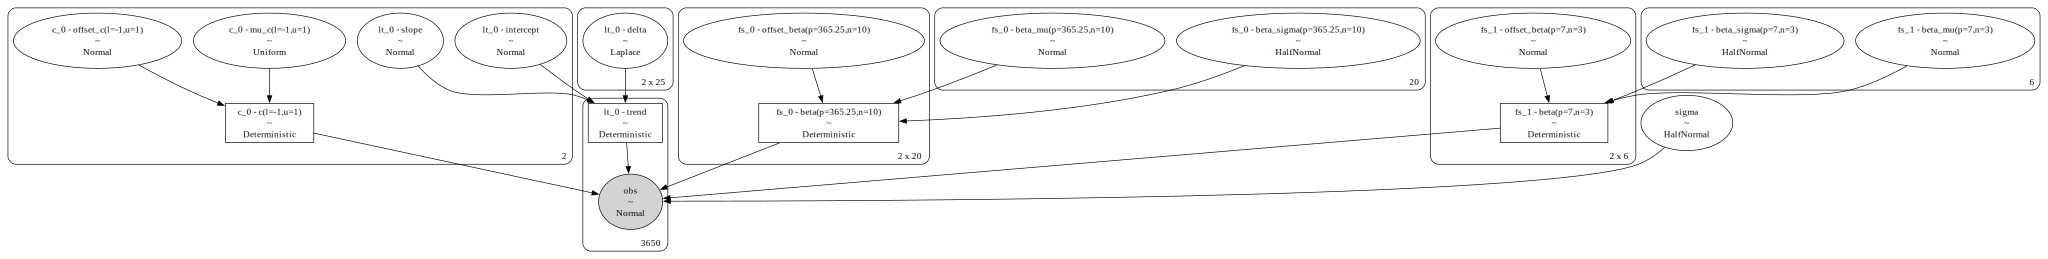

In [70]:
pm.model_to_graphviz(model.model)

### Prophet 3 year all

In [34]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [98]:
train_df_prophet, test_df_prophet, scales_prophet = (
    generate_train_test_df_financial_crisis(
        window=365 * 3, horizon=365, dfs=dfs, for_prophet=True
    )
)
train_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
2434,1305.585022,1312.690033,1305.055023,1311.570007,1308.725021,2006-09-02,^GSPC,0.837808
2435,1307.369995,1313.350037,1306.309998,1312.130005,1309.790009,2006-09-03,^GSPC,0.838490
2436,1309.154968,1314.010040,1307.564972,1312.690002,1310.854996,2006-09-04,^GSPC,0.839171
2437,1310.939941,1314.670044,1308.819946,1313.250000,1311.919983,2006-09-05,^GSPC,0.839853
2438,1313.040039,1313.040039,1299.280029,1300.260010,1306.405029,2006-09-06,^GSPC,0.836323
...,...,...,...,...,...,...,...,...
3524,1027.810059,1033.329956,1016.200012,1030.979980,1027.080002,2009-08-27,^GSPC,0.657507
3525,1031.619995,1039.469971,1023.130005,1028.930054,1030.787506,2009-08-28,^GSPC,0.659880
3526,1029.483317,1034.716634,1020.293335,1026.160034,1027.663330,2009-08-29,^GSPC,0.657880
3527,1027.346639,1029.963298,1017.456665,1023.390015,1024.539154,2009-08-30,^GSPC,0.655880


In [99]:
test_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
3529,1019.520020,1028.449951,996.280029,998.039978,1010.572495,2009-09-01,^GSPC,0.646939
3530,996.070007,1000.340027,991.969971,994.750000,995.782501,2009-09-02,^GSPC,0.637471
3531,996.119995,1003.429993,992.250000,1003.239990,998.759995,2009-09-03,^GSPC,0.639377
3532,1003.840027,1016.479980,1001.650024,1016.400024,1009.592514,2009-09-04,^GSPC,0.646312
3533,1007.547516,1018.877472,1005.905014,1018.647522,1012.744381,2009-09-05,^GSPC,0.648330
...,...,...,...,...,...,...,...,...
3889,1049.270020,1065.209961,1039.699951,1064.589966,1054.692474,2010-08-27,^GSPC,0.675184
3890,1053.813354,1064.939982,1042.729980,1059.366659,1055.212494,2010-08-28,^GSPC,0.675516
3891,1058.356689,1064.670003,1045.760010,1054.143351,1055.732513,2010-08-29,^GSPC,0.675849
3892,1062.900024,1064.400024,1048.790039,1048.920044,1056.252533,2010-08-30,^GSPC,0.676182


In [110]:
prophet_forecasts = []

for df, df_test in tqdm(zip(train_df_prophet, test_df_prophet)):
    prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="multiplicative",
        # n_changepoints=306,
        # changepoint_range=0.8
    )
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    prophet_forecasts.append(prophet.predict(future))

prophet_metrics = get_prophet_metrics(test_df_prophet, prophet_forecasts, 365)
prophet_metrics

349it [02:40,  2.18it/s]


,mse,rmse,mae,mape
^GSPC,0.006707,0.081896,0.064208,0.088760
AAPL,0.019958,0.141272,0.113056,0.100996
MSFT,0.016954,0.130208,0.085884,0.123710
AMZN,0.074774,0.273448,0.209894,0.161714
JNJ,0.007314,0.085520,0.067982,0.077225
...,...,...,...,...
RL,0.020873,0.144473,0.132940,0.166253
FLS,0.025616,0.160049,0.150763,0.208794
UNM,0.010200,0.100997,0.074849,0.092858
SLG,0.005608,0.074886,0.068896,0.206318


In [111]:
prophet_metrics["mape"].mean()

0.1831577668202823

In [108]:
metrics.loc[prophet_metrics.iloc[:38].index + "_small"]["mape"].mean()

0.15158084818459852

In [109]:
metrics.loc[prophet_metrics.iloc[:38].index]["mape"].mean()

0.43145748130809447

### Prophet 9 years all

In [19]:
train_df_prophet, test_df_prophet, scales_prophet = (
    generate_train_test_df_financial_crisis(
        window=365 * 9, horizon=365, dfs=dfs[1:], for_prophet=True
    )
)
train_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
244,1.106864,1.140625,1.101562,0.948049,1.118234,2000-09-03,AAPL,0.156776
245,1.112863,1.142857,1.106585,0.944283,1.120431,2000-09-04,AAPL,0.157084
246,1.118862,1.145089,1.111607,0.940517,1.122628,2000-09-05,AAPL,0.157392
247,1.095982,1.113839,1.031250,0.880264,1.071149,2000-09-06,AAPL,0.150175
248,1.055804,1.117188,1.040179,0.933927,1.080079,2000-09-07,AAPL,0.151427
...,...,...,...,...,...,...,...,...
3524,6.026786,6.056071,5.886786,5.104968,6.005357,2009-08-27,AAPL,0.841950
3525,6.152500,6.160357,6.018929,5.123043,6.101250,2009-08-28,AAPL,0.855394
3526,6.103571,6.117024,5.994762,5.104565,6.066667,2009-08-29,AAPL,0.850545
3527,6.054643,6.073690,5.970596,5.086087,6.032083,2009-08-30,AAPL,0.845697


In [20]:
test_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
3529,5.999643,6.071429,5.890714,4.979940,5.966339,2009-09-01,AAPL,0.836479
3530,5.879286,5.986071,5.861071,4.976326,5.906428,2009-09-02,AAPL,0.828080
3531,5.944286,5.967857,5.892857,5.017600,5.938303,2009-09-03,AAPL,0.832549
3532,5.974286,6.096429,5.967500,5.130876,6.030179,2009-09-04,AAPL,0.845430
3533,6.025179,6.118214,6.011339,5.150609,6.065156,2009-09-05,AAPL,0.850334
...,...,...,...,...,...,...,...,...
3889,8.633929,8.664643,8.412857,7.279211,8.585179,2010-08-27,AAPL,1.203640
3890,8.622143,8.702024,8.473809,7.288047,8.609435,2010-08-28,AAPL,1.207041
3891,8.610357,8.739405,8.534761,7.296884,8.633690,2010-08-29,AAPL,1.210441
3892,8.598571,8.776786,8.595714,7.305720,8.657946,2010-08-30,AAPL,1.213842


In [21]:
prophet_forecasts_2 = []

for df, df_test in zip(train_df_prophet, test_df_prophet):
    prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="multiplicative",
    )
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    prophet_forecasts_2.append(prophet.predict(future))

prophet_metrics_2 = get_prophet_metrics(test_df_prophet, prophet_forecasts, 365)
prophet_metrics_2

AAPL-mape: 0.5716184823964642
MSFT-mape: 0.48252246589876513
AMZN-mape: 0.468101414474341
JNJ-mape: 0.15907303877625711
JPM-mape: 0.390057087619134
PG-mape: 0.27950751813745073
UNH-mape: 0.7159742157302315
DIS-mape: 0.494542825595489
NVDA-mape: 1.2116480227510187
HD-mape: 0.33216263404168855
VZ-mape: 0.2175258472789508
ADBE-mape: 0.4753042883070506
CMCSA-mape: 0.3641038597473838
BAC-mape: 1.5050404686765997
KO-mape: 0.3382585614999315
MRK-mape: 0.6756032323213699
PEP-mape: 0.3458793905339805
T-mape: 0.3683305483676449
PFE-mape: 0.4176848848070181
INTC-mape: 0.49807145747862086
WMT-mape: 0.036340358677011575
ABT-mape: 0.1386193868450951
CSCO-mape: 0.48445019079807194
TMO-mape: 0.4333254787216663
NKE-mape: 0.33272230723087187
XOM-mape: 0.13039772533772115
QCOM-mape: 0.09891232367612118
COST-mape: 0.4004556284286251
CVX-mape: 0.2969148588924672
MCD-mape: 0.12154337858636981
MDT-mape: 0.41145068794338596
NEE-mape: 0.16394270866769883
TXN-mape: 0.5940375442173805
HON-mape: 0.677285712693941